# Vývoj platů zubních techniků v ČR (2017–2024)

Analýza vývoje hrubých měsíčních mezd odborných pracovníků v oblasti zubní techniky
(CZ-ISCO 3214) na základě dat z ISPV – Informačního systému o průměrném výdělku.

### O zdroji dat

ISPV je oficiální statistické šetření řízené Ministerstvem práce a sociálních věcí.
Pro vybrané firmy je **povinné ze zákona** – data pochází přímo z jejich mzdových
systémů za každého jednotlivého zaměstnance (anonymizovaně). Nejde tedy o dotazník
ani o odhad, ale o skutečné vyplacené mzdy.

Ve mzdové sféře (soukromý sektor) jde o výběrové šetření – nezahrnuje všechny firmy,
ale statisticky reprezentativní vzorek. Proto u malých profesí (jako zubní technici,
~2–3,5 tis. osob) mohou některé roky chybět kvůli nedostatečné velikosti vzorku.

### Použité statistické ukazatele

- **Medián** – prostřední hodnota: polovina zaměstnanců vydělává méně, polovina více
- **Průměr** – aritmetický průměr, ovlivněný extrémně vysokými/nízkými hodnotami
- **Kvartily (Q1, Q3)** – ohraničují prostředních 50 % zaměstnanců

Zdroj: [ISPV/MPSV ČR](https://www.mpsv.cz/ispv) | [Metodika](https://www.ispv.cz/cz/Vysledky-setreni/Metodika.aspx)


In [1]:
#načtení knihoven:
import pandas as pd
import matplotlib.pyplot as plt
import os

## Sběr dat

Soubory se stahuji automaticky z webu MPSV – notebook je plně reprodukovatelný
bez nutnosti ručního nahrávání. Používáme pouze celé roky (2017–2024)
pro srovnatelnost dat. Zdroje jsou přímo z webu IPSV. (Informační systém o průměrném výdělku)
ISPV (https://www.ispv.cz)

In [2]:
# Stažení dat přímo z webu MPSV
import urllib.request

# Roční publikace ISPV – mzdová sféra (soukromý sektor)
soubory_ke_stazeni = {
    "ISPV_174_MZS.xlsx": "https://www.mpsv.cz/cms/documents/e812e592-ec6e-4493-e2c3-cf4725946b06/ISPV_174_MZS.xlsx",
    "ISPV_184_MZS.xlsx": "https://www.mpsv.cz/cms/documents/8d6247cd-e3e2-92ca-4903-58fb6629aab4/ISPV_184_MZS.xlsx",
    "ISPV_194_MZS.xlsx": "https://www.mpsv.cz/cms/documents/8cfa82d7-5cd2-86bb-22a1-14c2b7e4dd83/ISPV_194_MZS.xlsx",
    "ISPV_204_MZS.xlsx": "https://www.mpsv.cz/cms/documents/7f7e4a82-845c-6ccf-03bd-5a61cf5725e0/ISPV_204_MZS.xlsx",
    "ISPV_214_MZS.xlsx": "https://www.mpsv.cz/cms/documents/67eaa908-4e87-22ae-e701-55374db2a9ac/ISPV_214_MZS.xlsx",
    "CR_224_MZS.xlsx":   "https://www.mpsv.cz/cms/documents/0b96b491-8b6b-d823-2b4b-fe3c290ddf7d/CR_224_MZS.xlsx",
    "ISPV_234_MZS.xlsx": "https://www.mpsv.cz/cms/documents/fc828308-c763-f166-ad89-21f533cc5b21/ISPV_234_MZS.xlsx",
    "ISPV_244_MZS.xlsx": "https://www.mpsv.cz/cms/documents/6178a1a8-c722-32d5-c4be-cd2b930ea750/ISPV_244_MZS.xlsx",
    "ISPV_252_MZS.xlsx": "https://www.mpsv.cz/cms/documents/363f937c-1dc7-712f-9b8b-d554d7699da3/ISPV_252_MZS.xlsx",
}

os.makedirs("data", exist_ok=True)

for nazev, url in soubory_ke_stazeni.items():
    cesta = os.path.join("data", nazev)
    if os.path.exists(cesta):
        print(f"  ✓ {nazev} – už staženo")
        continue
    try:
        req = urllib.request.Request(url, headers={"User-Agent": "Mozilla/5.0"})
        with urllib.request.urlopen(req, timeout=30) as response:
            with open(cesta, "wb") as f:
                f.write(response.read())
        print(f"  ✓ {nazev} – staženo")
    except Exception as e:
        print(f"  ✗ {nazev} – chyba: {e}")

  ✓ ISPV_174_MZS.xlsx – už staženo
  ✓ ISPV_184_MZS.xlsx – už staženo
  ✓ ISPV_194_MZS.xlsx – už staženo
  ✓ ISPV_204_MZS.xlsx – už staženo
  ✓ ISPV_214_MZS.xlsx – už staženo
  ✓ CR_224_MZS.xlsx – už staženo
  ✓ ISPV_234_MZS.xlsx – už staženo
  ✓ ISPV_244_MZS.xlsx – už staženo
  ✓ ISPV_252_MZS.xlsx – už staženo


In [3]:
#Kontrola co je staženo
soubory = sorted([f for f in os.listdir("data") if f.endswith(".xlsx")])

print(f"Staženo {len(soubory)} souborů:")
for s in soubory:
    print(f"  - {s}")

Staženo 9 souborů:
  - CR_224_MZS.xlsx
  - ISPV_174_MZS.xlsx
  - ISPV_184_MZS.xlsx
  - ISPV_194_MZS.xlsx
  - ISPV_204_MZS.xlsx
  - ISPV_214_MZS.xlsx
  - ISPV_234_MZS.xlsx
  - ISPV_244_MZS.xlsx
  - ISPV_252_MZS.xlsx


## Průzkum struktury dat

Každý soubor ISPV obsahuje více listů. Listy začínající na **M** = měsíční mzdy,
**T** = hodinové tarify, **V** = výdělky. Pro naši analýzu používáme list **MZS-M8**
(hrubá měsíční mzda podle podskupin zaměstnání).

In [4]:
# Průzkum struktury
xl = pd.ExcelFile("data/ISPV_244_MZS.xlsx")

print("Listy v souboru:")
for sheet in xl.sheet_names:
    print(f"  - {sheet}")

Listy v souboru:
  - MZS-M0
  - MZS-M1
  - MZS-M2
  - MZS-M3
  - MZS-M4
  - MZS-M5_6
  - MZS-M7
  - MZS-M8
  - MZS-T0
  - MZS-T1
  - MZS-T2_4
  - MZS-T5_6
  - MZS-T7
  - MZS-T8
  - MZS-V0
  - MZS-V1
  - MZS-V7
  - MZS-V8


## Extrakce dat

V každém souboru hledáme kód CZ-ISCO 3214 (zubní technici) v listu MZS-M8.
Extrahujeme medián, průměr a kvartilové rozpětí mezd.

In [5]:
# Průzkum struktury dat - Řádek 3214 (zubní technik) ve všech souborech
vysledky = []

for soubor in sorted(os.listdir("data")):
    if not soubor.endswith(".xlsx"):
        continue

    # Rok z názvu souboru: ISPV_244 → "24" → 2024
    kod = soubor.split("_")[1][:2]
    rok = 2000 + int(kod)

    # Načtení listu MZS-M8, bez hlavičky (data jsou nepravidelná)
    df = pd.read_excel(f"data/{soubor}", sheet_name="MZS-M8", header=None)

    # Hledání  řádku, kde první sloupec začíná "3214"
    maska = df[0].astype(str).str.startswith("3214")
    radek = df[maska]

    if radek.empty:
        print(f"  ✗ {soubor} ({rok}) – kód 3214 nenalezen!")
        continue

    # První (a jediný) nalezený řádek
    r = radek.iloc[0]

    print(f"  ✓ {rok}: medián = {r[2]}, průměr = {r[7]}")

    vysledky.append({
        "rok": rok,
        "nazev": r[0],
        "pocet_tisic": r[1],
        "median": r[2],
        "decil_1": r[3],
        "kvartil_1": r[4],
        "kvartil_3": r[5],
        "decil_9": r[6],
        "prumer": r[7],
    })

# Tabulku z výsledků
# Seřazení podle roku a ponechání jen celých roků 2017-2024
df_zubar = pd.DataFrame(vysledky)
df_zubar = df_zubar[df_zubar["rok"] <= 2024]
df_zubar = df_zubar.sort_values("rok").reset_index(drop=True)
df_zubar

  ✓ 2022: medián = 31815.6038, průměr = 37241.0753
  ✓ 2017: medián = 27228.4251, průměr = 27275.93
  ✗ ISPV_184_MZS.xlsx (2018) – kód 3214 nenalezen!
  ✓ 2019: medián = 27322.1956, průměr = 32684.5481
  ✓ 2020: medián = 28416.3649, průměr = 34927.511
  ✓ 2021: medián = 30387.9773, průměr = 36767.7771
  ✓ 2023: medián = 32229.012, průměr = 38163.6269
  ✓ 2024: medián = 36433.2907, průměr = 41586.4962
  ✓ 2025: medián = 40192.8093, průměr = 47222.5233


,rok,nazev,pocet_tisic,median,decil_1,kvartil_1,kvartil_3,decil_9,prumer
0,2017,3214 Odborní pracovníci v oblasti zubní techni...,2.8234,27228.4251,15915.7705,19688.6574,31378.2947,38317.2473,27275.9300
1,2019,3214 Odborní pracovníci v oblasti zubní techni...,3.0703,27322.1956,20315.7327,22692.4987,38451.2676,49253.0622,32684.5481
2,2020,3214 Odborní pracovníci v oblasti zubní techni...,2.1938,28416.3649,21833.3470,23997.8546,38938.2888,59242.1278,34927.5110
3,2021,3214 Odborní pracovníci v oblasti zubní techni...,2.0214,30387.9773,22858.8655,25506.2208,45813.5101,57082.6996,36767.7771
4,2022,3214 Odborní pracovníci v oblasti zubní techni...,3.5155,31815.6038,23193.0516,27126.1370,43112.8946,61454.2225,37241.0753
5,2023,3214 Odborní pracovníci v oblasti zubní techni...,3.4743,32229.0120,23435.3838,27720.0620,47421.5699,59643.2323,38163.6269
6,2024,3214 Odborní pracovníci v oblasti zubní techni...,3.5098,36433.2907,25445.9125,30678.5974,50172.1074,67630.6882,41586.4962


In [6]:
# Uložení vyextrahovaných dat do CSV
df_zubar.to_csv("data/zubni_technik_2017_2024.csv", index=False)
print("✓ Data uložena do data/zubni_technik_2017_2024.csv")
df_zubar[["rok", "pocet_tisic", "median", "prumer", "kvartil_1", "kvartil_3"]]

✓ Data uložena do data/zubni_technik_2017_2024.csv


,rok,pocet_tisic,median,prumer,kvartil_1,kvartil_3
0,2017,2.8234,27228.4251,27275.9300,19688.6574,31378.2947
1,2019,3.0703,27322.1956,32684.5481,22692.4987,38451.2676
2,2020,2.1938,28416.3649,34927.5110,23997.8546,38938.2888
3,2021,2.0214,30387.9773,36767.7771,25506.2208,45813.5101
4,2022,3.5155,31815.6038,37241.0753,27126.1370,43112.8946
5,2023,3.4743,32229.0120,38163.6269,27720.0620,47421.5699
6,2024,3.5098,36433.2907,41586.4962,30678.5974,50172.1074


## Vizualizace

Hlavní graf zobrazuje vývoj mediánu a průměru s kvartilovou distribucí.
Medián je zvýrazněn jako klíčový ukazatel – na rozdíl od průměru
není ovlivněn extrémními hodnotami.

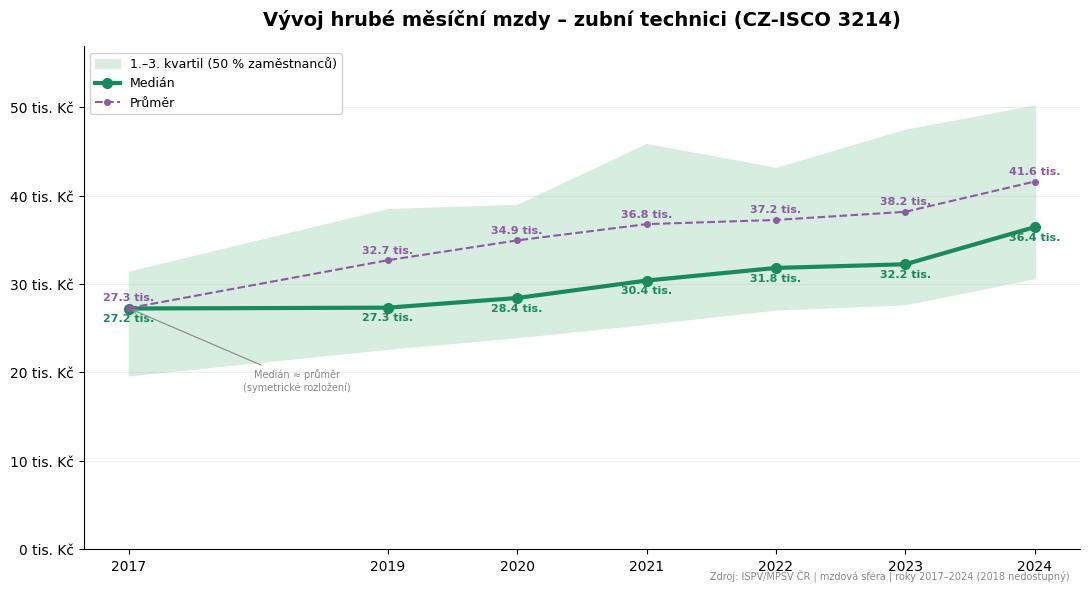

In [7]:
# Vizualizace vývoje platů zubních techniků 2017–2024

ZELENA = "#1A8A5C"
SEDA_PRUMER = "#8B5CA0"
SEDA = "#888888"
POZADI_PASMO = "#D6EDDF"

fig, ax = plt.subplots(figsize=(11, 6))

# Pásmo kvartilů
ax.fill_between(df_zubar["rok"], df_zubar["kvartil_1"], df_zubar["kvartil_3"],
                color=POZADI_PASMO, label="1.–3. kvartil (50 % zaměstnanců)")

# Linie – medián dominantní, průměr podřízený
ax.plot(df_zubar["rok"], df_zubar["median"], "o-", color=ZELENA,
        linewidth=3, markersize=7, label="Medián", zorder=3)
ax.plot(df_zubar["rok"], df_zubar["prumer"], "o--", color=SEDA_PRUMER,
        linewidth=1.5, markersize=4, label="Průměr", zorder=3)

# Hodnoty přímo v grafu
for _, r in df_zubar.iterrows():
    ax.text(r["rok"], r["median"] - 1500, f'{r["median"]/1000:.1f} tis.',
            ha="center", fontsize=8, color=ZELENA, fontweight="bold")
    ax.text(r["rok"], r["prumer"] + 800, f'{r["prumer"]/1000:.1f} tis.',
            ha="center", fontsize=8, color=SEDA_PRUMER, fontweight="bold")

# Osa Y od nuly
ax.set_ylim(0, ax.get_ylim()[1] * 1.1)

# Formátování osy Y
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f"{x/1000:.0f} tis. Kč"))

# Popisky
ax.set_title("Vývoj hrubé měsíční mzdy – zubní technici (CZ-ISCO 3214)",
             fontsize=14, fontweight="bold", pad=15)
ax.set_xlabel("")
ax.set_ylabel("")

# Osa X
ax.set_xticks(df_zubar["rok"])

# Legenda
ax.legend(loc="upper left", framealpha=0.9, fontsize=9)

# Čistý vzhled
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.grid(axis="y", alpha=0.2)

# Anotace k roku 2017
ax.annotate("Medián ≈ průměr\n(symetrické rozložení)",
            xy=(2017, 27250), xytext=(2018.3, 18000),
            fontsize=7, color=SEDA, ha="center",
            arrowprops=dict(arrowstyle="->", color=SEDA, lw=0.8))

# Zdroj dat
ax.text(0.99, -0.06, "Zdroj: ISPV/MPSV ČR | mzdová sféra | roky 2017–2024 (2018 nedostupný)",
        transform=ax.transAxes, fontsize=7, color=SEDA, ha="right")

plt.tight_layout()
plt.savefig("data/graf_zubni_technik.png", dpi=150, bbox_inches="tight")
plt.show()

## Meziroční změny:

In [8]:
# Meziroční změny v %
df_zmeny = df_zubar[["rok", "median", "prumer", "pocet_tisic"]].copy()

# pct_change() = procentuální změna oproti předchozímu řádku
df_zmeny["median_zmena_%"] = df_zubar["median"].pct_change() * 100
df_zmeny["prumer_zmena_%"] = df_zubar["prumer"].pct_change() * 100

# Zaokrouhlení pro čitelnost
df_zmeny["median"] = df_zmeny["median"].round(0).astype(int)
df_zmeny["prumer"] = df_zmeny["prumer"].round(0).astype(int)
df_zmeny["median_zmena_%"] = df_zmeny["median_zmena_%"].round(1)
df_zmeny["prumer_zmena_%"] = df_zmeny["prumer_zmena_%"].round(1)

df_zmeny

,rok,median,prumer,pocet_tisic,median_zmena_%,prumer_zmena_%
0,2017,27228,27276,2.8234,NaN,NaN
1,2019,27322,32685,3.0703,0.3,19.8
2,2020,28416,34928,2.1938,4.0,6.9
3,2021,30388,36768,2.0214,6.9,5.3
4,2022,31816,37241,3.5155,4.7,1.3
5,2023,32229,38164,3.4743,1.3,2.5
6,2024,36433,41586,3.5098,13.0,9.0


## Závěr

- **Medián** hrubé měsíční mzdy vzrostl z 27,2 tis. Kč (2017) na 36,4 tis. Kč (2024), tedy o **34 %**
- **Průměrná mzda** rostla rychleji (52 %) – rostoucí rozdíl naznačuje zvyšující se nerovnost v odměňování
- Největší meziroční nárůst mediánu nastal v roce **2024 (+13,0 %)**
- Rok **2018** není v datech dostupný (pravděpodobně nedostatečný vzorek)

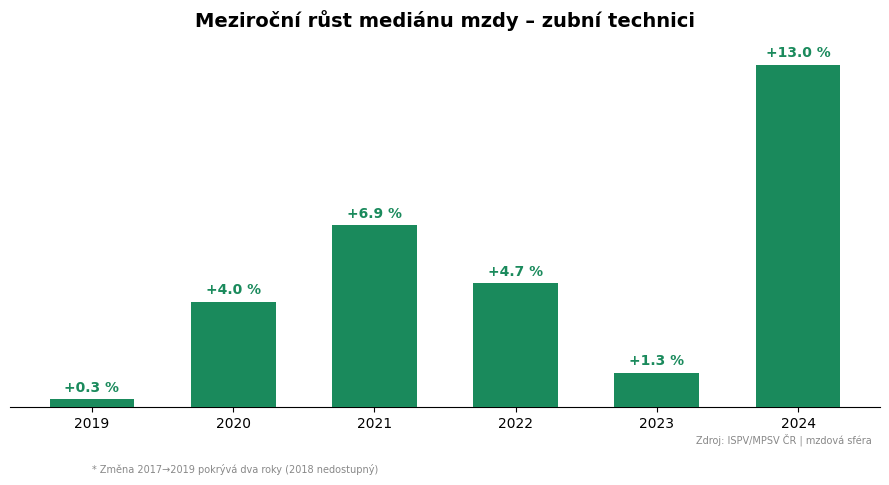

In [9]:
# === MEZIROČNÍ ZMĚNY – sloupcový graf ===
df_plot = df_zmeny.dropna(subset=["median_zmena_%"]).copy()

ZELENA = "#1A8A5C"
SEDA = "#888888"

fig, ax = plt.subplots(figsize=(9, 5))

# Sloupce
bars = ax.bar(df_plot["rok"].astype(str), df_plot["median_zmena_%"],
              color=ZELENA, width=0.6, zorder=3)

# Hodnoty nad sloupci
for bar, val in zip(bars, df_plot["median_zmena_%"]):
    ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.3,
            f"+{val:.1f} %", ha="center", fontsize=10, fontweight="bold",
            color=ZELENA)

# Popisky
ax.set_title("Meziroční růst mediánu mzdy – zubní technici",
             fontsize=14, fontweight="bold", pad=15)
ax.set_xlabel("")
ax.set_ylabel("")

# Čistý vzhled
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["left"].set_visible(False)
ax.set_yticks([])
ax.grid(False)

# Pozn. k 2019
ax.text(0, -2.5, "* Změna 2017→2019 pokrývá dva roky (2018 nedostupný)",
        fontsize=7, color=SEDA)

# Zdroj
ax.text(0.99, -0.1, "Zdroj: ISPV/MPSV ČR | mzdová sféra",
        transform=ax.transAxes, fontsize=7, color=SEDA, ha="right")

plt.tight_layout()
plt.savefig("data/graf_meziroční_zmeny.png", dpi=150, bbox_inches="tight")
plt.show()